In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import jax.numpy as jnp
from jaxopt import GaussNewton
import matplotlib.dates as mdates
from scipy.optimize import least_squares
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# DATASET BITCOIN

In [2]:
# Read data from the CSV file
data = pd.read_csv('Bitcoin Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].str.replace(',', '').astype(float)
data = data.sort_index(ascending=False)
data = data.reset_index(drop=True)

data

,Date,Price,Open,High,Low,Vol.,Change %
0,2013-03-01,34.5,33.4,34.9,32.9,39.79K,3.36%
1,2013-03-02,34.3,34.5,34.8,33.2,36.66K,-0.72%
2,2013-03-03,34.5,34.3,34.5,33.8,12.53K,0.73%
3,2013-03-04,36.2,34.5,36.7,34.2,46.77K,4.78%
4,2013-03-05,40.3,36.2,40.7,36.2,85.43K,11.56%
...,...,...,...,...,...,...,...
4106,2024-05-28,68366.0,69428.3,69560.7,67299.9,71.39K,-1.53%
4107,2024-05-29,67635.8,68366.2,68897.6,67143.2,52.13K,-1.07%
4108,2024-05-30,68354.7,67631.3,69504.7,67138.4,66.84K,1.06%
4109,2024-05-31,67530.1,68352.3,69018.2,66676.8,61.51K,-1.21%


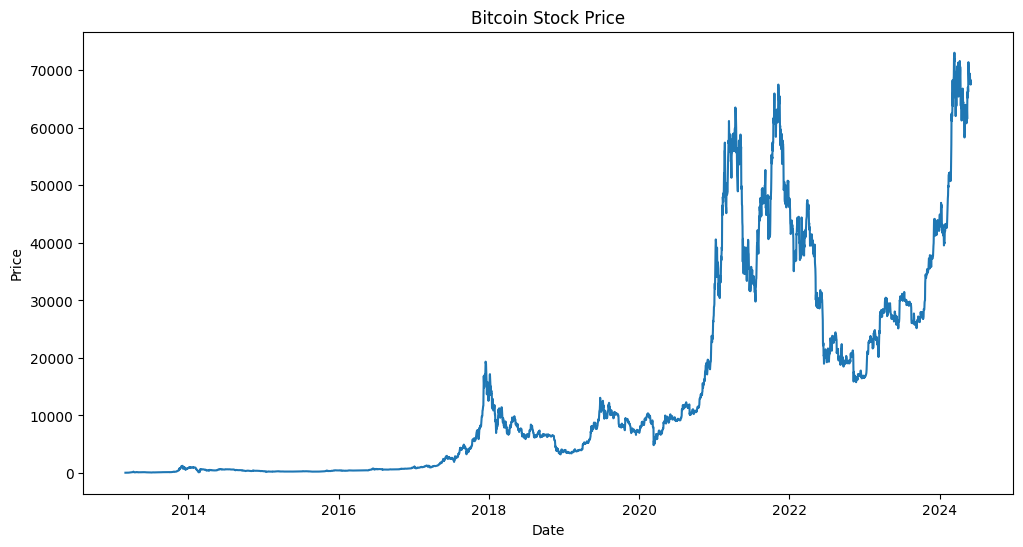

In [3]:
# Visualize the Bitcoin price data
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Price'])
plt.title('Bitcoin Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### RETIO 6:4

In [4]:
# Split the data into training and testing sets 6:4
train_size = int(0.6 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Perform Gauss-Newton optimization on the training data
x_train = np.arange(len(train_data))
y_train = train_data['Price'].values

In [5]:
# Define the model function and its Jacobian for Gauss-Newton optimization
def model_func(params, x):
    a, b, c = params
    return a * np.exp(b * x) + c

def model_jac(params, x):
    a, b, c = params
    J = np.empty((x.size, params.size))
    J[:, 0] = np.exp(b * x)
    J[:, 1] = a * x * np.exp(b * x)
    J[:, 2] = 1
    return J

In [6]:
# Initial parameters guess
p0 = np.array([1.0, 0.01, 0.0])

# Gauss-Newton optimization using scipy's least_squares
res = least_squares(lambda params: model_func(params, x_train) - y_train, p0, jac=lambda params: model_jac(params, x_train))

# Extract optimized parameters
a, b, c = res.x

In [7]:
# Function to predict prices for next `n` days
def predict_future_prices(a, b, c, n):
    # Generate future dates and x values
    future_dates = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n)
    future_x = np.arange(len(data), len(data) + n)
    future_y = model_func([a, b, c], future_x)
    return future_dates, future_y

# Predict future prices for the next 30, 60, and 90 days
future_dates_30, future_prices_30 = predict_future_prices(a, b, c, 30)
future_dates_60, future_prices_60 = predict_future_prices(a, b, c, 60)
future_dates_90, future_prices_90 = predict_future_prices(a, b, c, 90)

# Predict test data
x_test = np.arange(train_size, len(data))
pred_test = model_func([a, b, c], x_test)

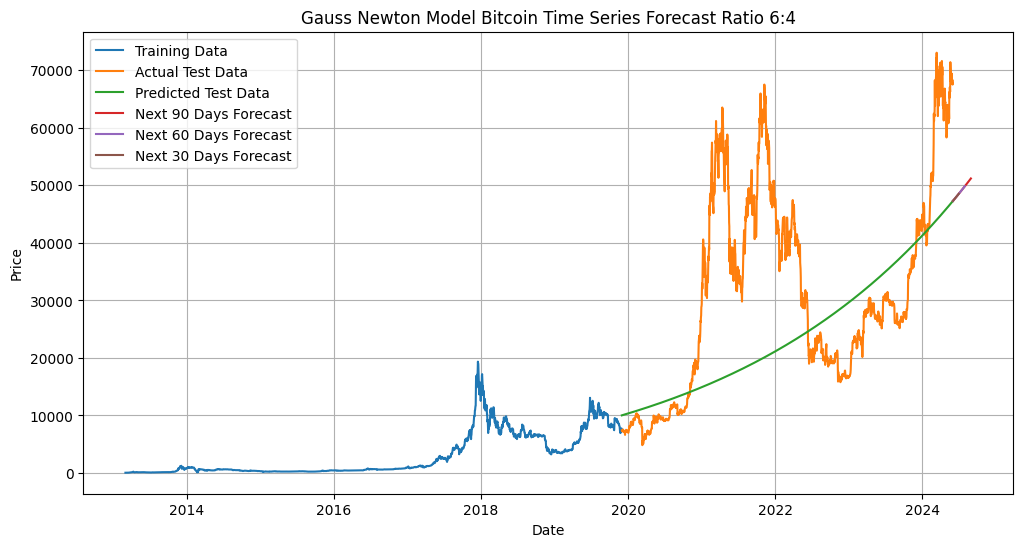

In [8]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Price'], label='Training Data')
plt.plot(test_data['Date'], test_data['Price'], label='Actual Test Data')
plt.plot(test_data['Date'], pred_test, label='Predicted Test Data')
plt.plot(future_dates_90, future_prices_90, label='Next 90 Days Forecast')
plt.plot(future_dates_60, future_prices_60, label='Next 60 Days Forecast')
plt.plot(future_dates_30, future_prices_30, label='Next 30 Days Forecast')
plt.title('Gauss Newton Model Bitcoin Time Series Forecast Ratio 6:4')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data['Price'].values if isinstance(test_data['Price'], pd.Series) else test_data['Price']

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Define function for Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate RMSE, MAE, MAPE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
test_mae = np.mean(np.abs(test_data - pred_test))
test_mape = mean_absolute_percentage_error(test_data, pred_test)

# Print RMSE, MAE, MAPE
print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)

Testing RMSE:  17074.424149698385
Testing MAE:  12552.755328023184
Testing MAPE:  37.39992521943193


### RETIO 7:3

In [10]:
# Split the data into training and testing sets 7:3
train_size = int(0.7 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Perform Gauss-Newton optimization on the training data
x_train = np.arange(len(train_data))
y_train = train_data['Price'].values

In [11]:
# Define the model function and its Jacobian for Gauss-Newton optimization
def model_func(params, x):
    a, b, c = params
    return a * np.exp(b * x) + c

def model_jac(params, x):
    a, b, c = params
    J = np.empty((x.size, params.size))
    J[:, 0] = np.exp(b * x)
    J[:, 1] = a * x * np.exp(b * x)
    J[:, 2] = 1
    return J

In [12]:
# Initial parameters guess
p0 = np.array([1.0, 0.01, 0.0])

# Gauss-Newton optimization using scipy's least_squares
res = least_squares(lambda params: model_func(params, x_train) - y_train, p0, jac=lambda params: model_jac(params, x_train))

# Extract optimized parameters
a, b, c = res.x

In [13]:
# Function to predict prices for next `n` days
def predict_future_prices(a, b, c, n):
    # Generate future dates and x values
    future_dates = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n)
    future_x = np.arange(len(data), len(data) + n)
    future_y = model_func([a, b, c], future_x)
    return future_dates, future_y

# Predict future prices for the next 30, 60, and 90 days
future_dates_30, future_prices_30 = predict_future_prices(a, b, c, 30)
future_dates_60, future_prices_60 = predict_future_prices(a, b, c, 60)
future_dates_90, future_prices_90 = predict_future_prices(a, b, c, 90)

# Predict test data
x_test = np.arange(train_size, len(data))
pred_test = model_func([a, b, c], x_test)

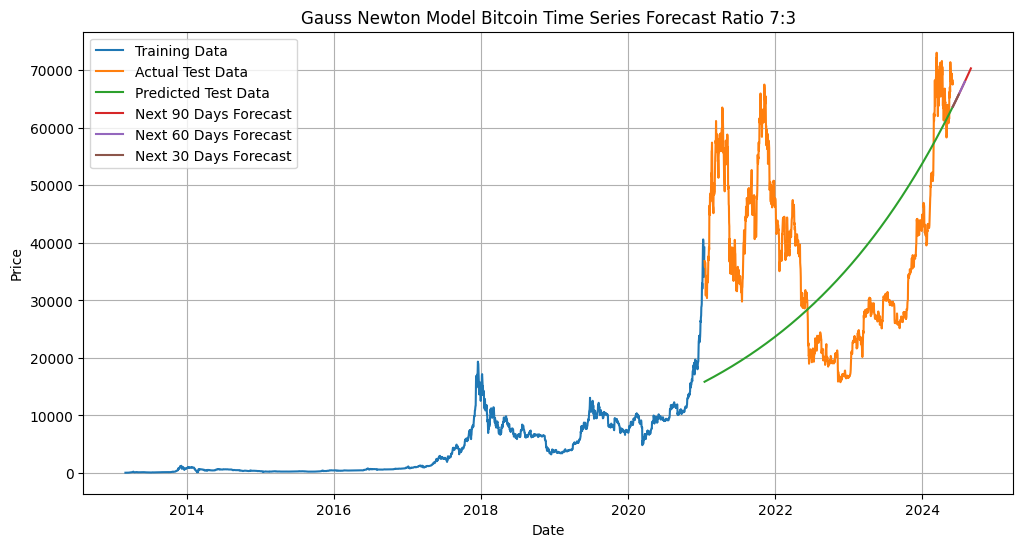

In [14]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Price'], label='Training Data')
plt.plot(test_data['Date'], test_data['Price'], label='Actual Test Data')
plt.plot(test_data['Date'], pred_test, label='Predicted Test Data')
plt.plot(future_dates_90, future_prices_90, label='Next 90 Days Forecast')
plt.plot(future_dates_60, future_prices_60, label='Next 60 Days Forecast')
plt.plot(future_dates_30, future_prices_30, label='Next 30 Days Forecast')
plt.title('Gauss Newton Model Bitcoin Time Series Forecast Ratio 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data['Price'].values if isinstance(test_data['Price'], pd.Series) else test_data['Price']

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Define function for Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate RMSE, MAE, MAPE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
test_mae = np.mean(np.abs(test_data - pred_test))
test_mape = mean_absolute_percentage_error(test_data, pred_test)

# Print RMSE, MAE, MAPE
print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)

Testing RMSE:  19714.681513924974
Testing MAE:  17183.643393914543
Testing MAPE:  49.48203411936613


### RETIO 8:2

In [16]:
# Split the data into training and testing sets 8:2
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Perform Gauss-Newton optimization on the training data
x_train = np.arange(len(train_data))
y_train = train_data['Price'].values

In [17]:
# Define the model function and its Jacobian for Gauss-Newton optimization
def model_func(params, x):
    a, b, c = params
    return a * np.exp(b * x) + c

def model_jac(params, x):
    a, b, c = params
    J = np.empty((x.size, params.size))
    J[:, 0] = np.exp(b * x)
    J[:, 1] = a * x * np.exp(b * x)
    J[:, 2] = 1
    return J

In [18]:
# Initial parameters guess
p0 = np.array([1.0, 0.01, 0.0])

# Gauss-Newton optimization using scipy's least_squares
res = least_squares(lambda params: model_func(params, x_train) - y_train, p0, jac=lambda params: model_jac(params, x_train))

# Extract optimized parameters
a, b, c = res.x

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20660\1693940958.py:4: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * x) + c
C:\Users\ASUS\AppData\Local\Temp\ipykernel_20660\1693940958.py:4: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(b * x) + c


In [19]:
# Function to predict prices for next `n` days
def predict_future_prices(a, b, c, n):
    # Generate future dates and x values
    future_dates = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n)
    future_x = np.arange(len(data), len(data) + n)
    future_y = model_func([a, b, c], future_x)
    return future_dates, future_y

# Predict future prices for the next 30, 60, and 90 days
future_dates_30, future_prices_30 = predict_future_prices(a, b, c, 30)
future_dates_60, future_prices_60 = predict_future_prices(a, b, c, 60)
future_dates_90, future_prices_90 = predict_future_prices(a, b, c, 90)

# Predict test data
x_test = np.arange(train_size, len(data))
pred_test = model_func([a, b, c], x_test)

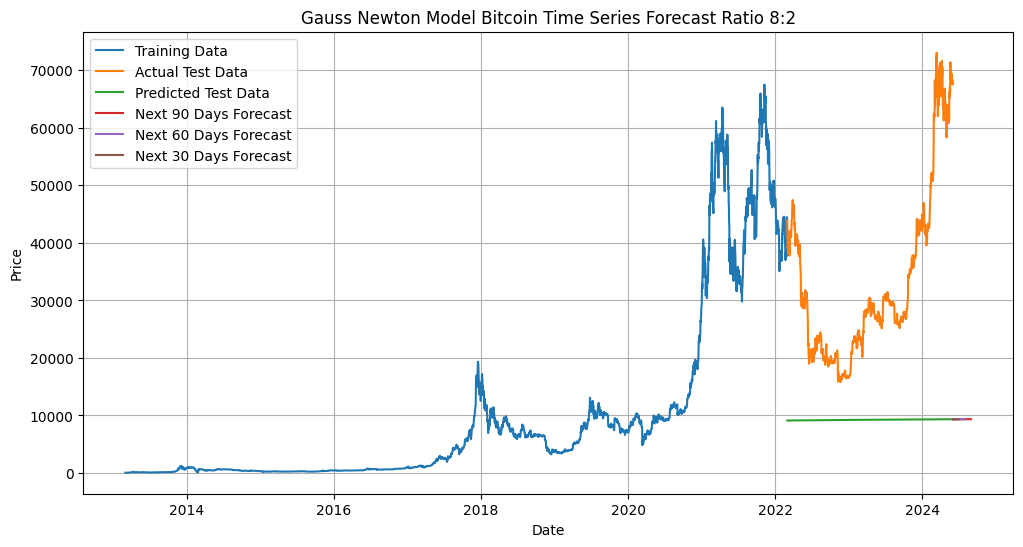

In [20]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Price'], label='Training Data')
plt.plot(test_data['Date'], test_data['Price'], label='Actual Test Data')
plt.plot(test_data['Date'], pred_test, label='Predicted Test Data')
plt.plot(future_dates_90, future_prices_90, label='Next 90 Days Forecast')
plt.plot(future_dates_60, future_prices_60, label='Next 60 Days Forecast')
plt.plot(future_dates_30, future_prices_30, label='Next 30 Days Forecast')
plt.title('Gauss Newton Model Bitcoin Time Series Forecast Ratio 8:2')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data['Price'].values if isinstance(test_data['Price'], pd.Series) else test_data['Price']

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Define function for Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate RMSE, MAE, MAPE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
test_mae = np.mean(np.abs(test_data - pred_test))
test_mape = mean_absolute_percentage_error(test_data, pred_test)

# Print RMSE, MAE, MAPE
print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)

Testing RMSE:  28057.43884113087
Testing MAE:  23937.01221567962
Testing MAPE:  67.41050168475714


# DATASET NASDAQ

In [22]:
# Read data from the CSV file
data = pd.read_csv('NASDAQ Composite Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    data[col] = data[col].str.replace(',', '').astype(float)
data = data.sort_index(ascending=False)
data = data.reset_index(drop=True)

data

,Date,Price,Open,High,Low,Vol.,Change %
0,2013-03-01,3169.74,3143.54,3171.50,3129.40,431.39M,0.30%
1,2013-03-04,3182.03,3159.46,3182.27,3154.79,397.77M,0.39%
2,2013-03-05,3224.13,3200.38,3227.31,3200.27,418.69M,1.32%
3,2013-03-06,3222.37,3233.31,3233.44,3217.67,377.54M,-0.05%
4,2013-03-07,3232.09,3224.50,3235.10,3221.47,365.78M,0.30%
...,...,...,...,...,...,...,...
2828,2024-05-24,16920.79,16786.79,16947.79,16771.58,953.61M,1.10%
2829,2024-05-28,17019.88,16988.31,17032.65,16917.51,1.10B,0.59%
2830,2024-05-29,16920.58,16879.35,16989.60,16873.97,1.15B,-0.58%
2831,2024-05-30,16737.08,16878.63,16900.46,16690.36,1.11B,-1.08%


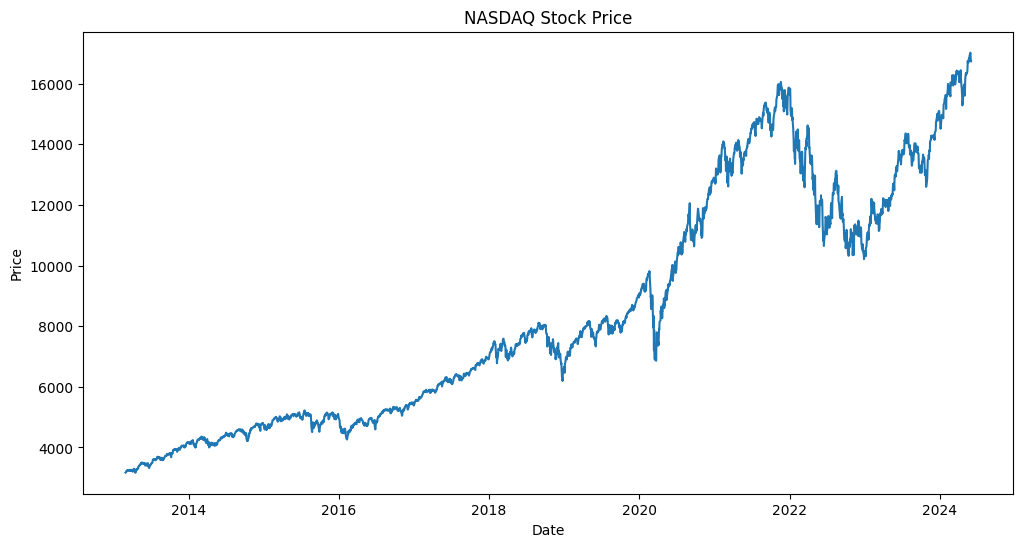

In [23]:
# Visualize the Bitcoin price data
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Price'])
plt.title('NASDAQ Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### RETIO 6:4

In [24]:
# Split the data into training and testing sets 6:4
train_size = int(0.6 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Perform Gauss-Newton optimization on the training data
x_train = np.arange(len(train_data))
y_train = train_data['Price'].values

In [25]:
# Define the model function and its Jacobian for Gauss-Newton optimization
def model_func(params, x):
    a, b, c = params
    return a * np.exp(b * x) + c

def model_jac(params, x):
    a, b, c = params
    J = np.empty((x.size, params.size))
    J[:, 0] = np.exp(b * x)
    J[:, 1] = a * x * np.exp(b * x)
    J[:, 2] = 1
    return J

In [26]:
# Initial parameters guess
p0 = np.array([1.0, 0.01, 0.0])

# Gauss-Newton optimization using scipy's least_squares
res = least_squares(lambda params: model_func(params, x_train) - y_train, p0, jac=lambda params: model_jac(params, x_train))

# Extract optimized parameters
a, b, c = res.x

In [27]:
# Function to predict prices for next `n` days
def predict_future_prices(a, b, c, n):
    # Generate future dates and x values
    future_dates = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n)
    future_x = np.arange(len(data), len(data) + n)
    future_y = model_func([a, b, c], future_x)
    return future_dates, future_y

# Predict future prices for the next 30, 60, and 90 days
future_dates_30, future_prices_30 = predict_future_prices(a, b, c, 30)
future_dates_60, future_prices_60 = predict_future_prices(a, b, c, 60)
future_dates_90, future_prices_90 = predict_future_prices(a, b, c, 90)

# Predict test data
x_test = np.arange(train_size, len(data))
pred_test = model_func([a, b, c], x_test)

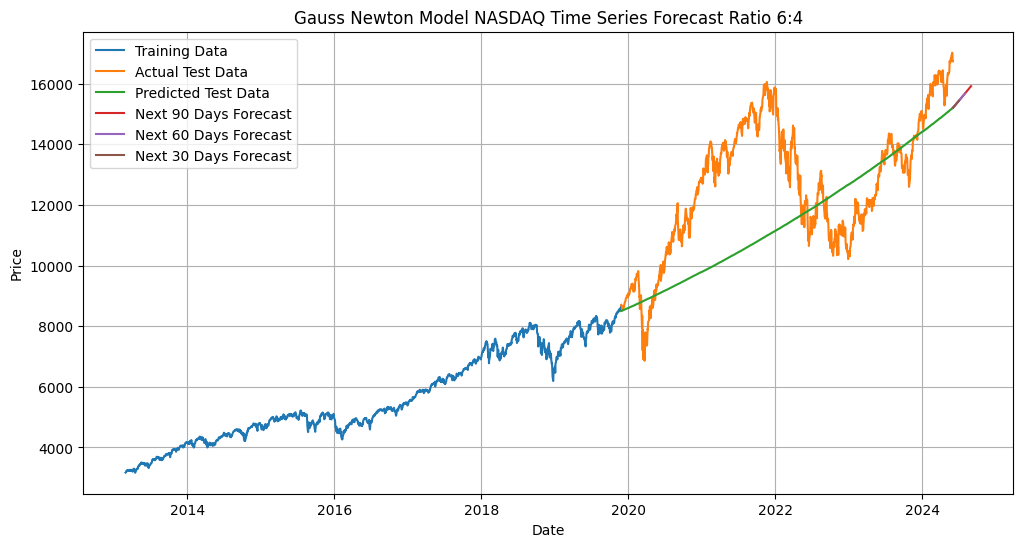

In [28]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Price'], label='Training Data')
plt.plot(test_data['Date'], test_data['Price'], label='Actual Test Data')
plt.plot(test_data['Date'], pred_test, label='Predicted Test Data')
plt.plot(future_dates_90, future_prices_90, label='Next 90 Days Forecast')
plt.plot(future_dates_60, future_prices_60, label='Next 60 Days Forecast')
plt.plot(future_dates_30, future_prices_30, label='Next 30 Days Forecast')
plt.title('Gauss Newton Model NASDAQ Time Series Forecast Ratio 6:4')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data['Price'].values if isinstance(test_data['Price'], pd.Series) else test_data['Price']

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Define function for Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate RMSE, MAE, MAPE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
test_mae = np.mean(np.abs(test_data - pred_test))
test_mape = mean_absolute_percentage_error(test_data, pred_test)

# Print RMSE, MAE, MAPE
print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)

Testing RMSE:  2236.785499675814
Testing MAE:  1752.495333219044
Testing MAPE:  13.349675115003656


### RETIO 7:3

In [30]:
# Split the data into training and testing sets 7:3
train_size = int(0.7 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Perform Gauss-Newton optimization on the training data
x_train = np.arange(len(train_data))
y_train = train_data['Price'].values

In [31]:
# Define the model function and its Jacobian for Gauss-Newton optimization
def model_func(params, x):
    a, b, c = params
    return a * np.exp(b * x) + c

def model_jac(params, x):
    a, b, c = params
    J = np.empty((x.size, params.size))
    J[:, 0] = np.exp(b * x)
    J[:, 1] = a * x * np.exp(b * x)
    J[:, 2] = 1
    return J

In [32]:
# Initial parameters guess
p0 = np.array([1.0, 0.01, 0.0])

# Gauss-Newton optimization using scipy's least_squares
res = least_squares(lambda params: model_func(params, x_train) - y_train, p0, jac=lambda params: model_jac(params, x_train))

# Extract optimized parameters
a, b, c = res.x

In [33]:
# Function to predict prices for next `n` days
def predict_future_prices(a, b, c, n):
    # Generate future dates and x values
    future_dates = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n)
    future_x = np.arange(len(data), len(data) + n)
    future_y = model_func([a, b, c], future_x)
    return future_dates, future_y

# Predict future prices for the next 30, 60, and 90 days
future_dates_30, future_prices_30 = predict_future_prices(a, b, c, 30)
future_dates_60, future_prices_60 = predict_future_prices(a, b, c, 60)
future_dates_90, future_prices_90 = predict_future_prices(a, b, c, 90)

# Predict test data
x_test = np.arange(train_size, len(data))
pred_test = model_func([a, b, c], x_test)

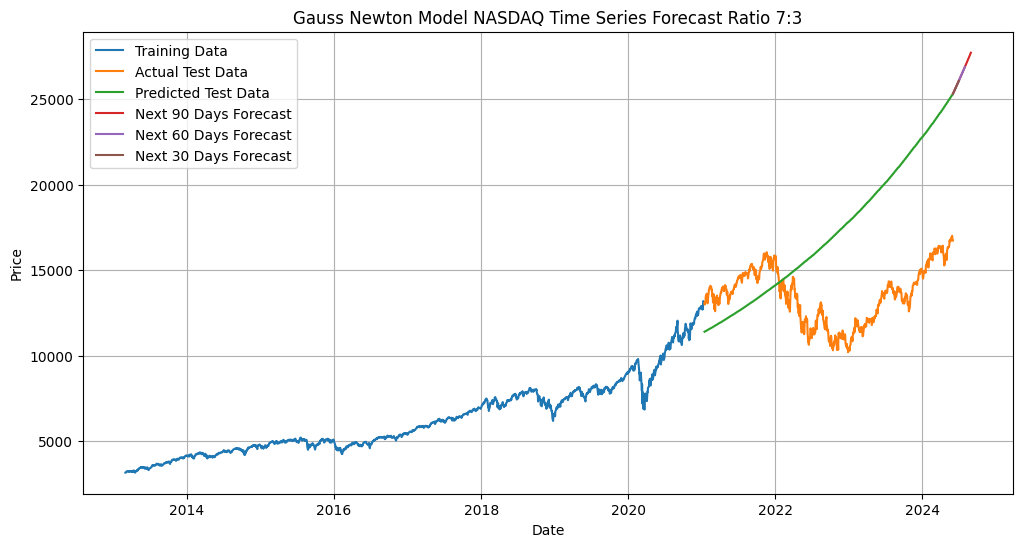

In [34]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Price'], label='Training Data')
plt.plot(test_data['Date'], test_data['Price'], label='Actual Test Data')
plt.plot(test_data['Date'], pred_test, label='Predicted Test Data')
plt.plot(future_dates_90, future_prices_90, label='Next 90 Days Forecast')
plt.plot(future_dates_60, future_prices_60, label='Next 60 Days Forecast')
plt.plot(future_dates_30, future_prices_30, label='Next 30 Days Forecast')
plt.title('Gauss Newton Model NASDAQ Time Series Forecast Ratio 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data['Price'].values if isinstance(test_data['Price'], pd.Series) else test_data['Price']

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Define function for Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate RMSE, MAE, MAPE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
test_mae = np.mean(np.abs(test_data - pred_test))
test_mape = mean_absolute_percentage_error(test_data, pred_test)

# Print RMSE, MAE, MAPE
print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)

Testing RMSE:  5481.794176638562
Testing MAE:  4723.687310028484
Testing MAPE:  35.859156174820406


### RETIO 8:2

In [36]:
# Split the data into training and testing sets 8:2
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Perform Gauss-Newton optimization on the training data
x_train = np.arange(len(train_data))
y_train = train_data['Price'].values

In [37]:
# Define the model function and its Jacobian for Gauss-Newton optimization
def model_func(params, x):
    a, b, c = params
    return a * np.exp(b * x) + c

def model_jac(params, x):
    a, b, c = params
    J = np.empty((x.size, params.size))
    J[:, 0] = np.exp(b * x)
    J[:, 1] = a * x * np.exp(b * x)
    J[:, 2] = 1
    return J

In [38]:
# Initial parameters guess
p0 = np.array([1.0, 0.01, 0.0])

# Gauss-Newton optimization using scipy's least_squares
res = least_squares(lambda params: model_func(params, x_train) - y_train, p0, jac=lambda params: model_jac(params, x_train))

# Extract optimized parameters
a, b, c = res.x

In [39]:
# Function to predict prices for next `n` days
def predict_future_prices(a, b, c, n):
    # Generate future dates and x values
    future_dates = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n)
    future_x = np.arange(len(data), len(data) + n)
    future_y = model_func([a, b, c], future_x)
    return future_dates, future_y

# Predict future prices for the next 30, 60, and 90 days
future_dates_30, future_prices_30 = predict_future_prices(a, b, c, 30)
future_dates_60, future_prices_60 = predict_future_prices(a, b, c, 60)
future_dates_90, future_prices_90 = predict_future_prices(a, b, c, 90)

# Predict test data
x_test = np.arange(train_size, len(data))
pred_test = model_func([a, b, c], x_test)

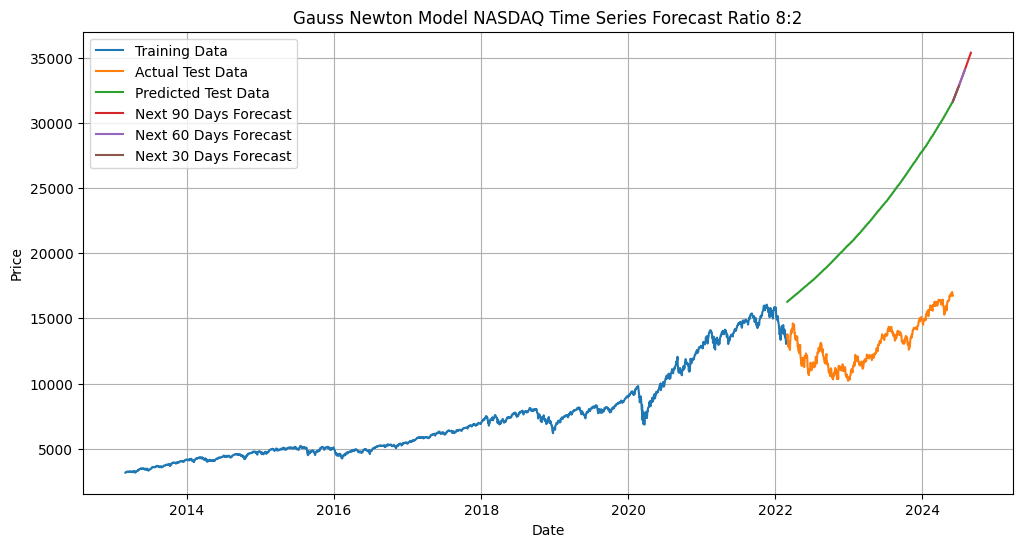

In [40]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Price'], label='Training Data')
plt.plot(test_data['Date'], test_data['Price'], label='Actual Test Data')
plt.plot(test_data['Date'], pred_test, label='Predicted Test Data')
plt.plot(future_dates_90, future_prices_90, label='Next 90 Days Forecast')
plt.plot(future_dates_60, future_prices_60, label='Next 60 Days Forecast')
plt.plot(future_dates_30, future_prices_30, label='Next 30 Days Forecast')
plt.title('Gauss Newton Model NASDAQ Time Series Forecast Ratio 8:2')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data['Price'].values if isinstance(test_data['Price'], pd.Series) else test_data['Price']

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Define function for Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate RMSE, MAE, MAPE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
test_mae = np.mean(np.abs(test_data - pred_test))
test_mape = mean_absolute_percentage_error(test_data, pred_test)

# Print RMSE, MAE, MAPE
print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)

Testing RMSE:  10355.15988068467
Testing MAE:  9847.95112432997
Testing MAPE:  74.83399530557946


# DATASET USD

In [42]:
# Read data from the CSV file
data = pd.read_csv('US Dollar Index Futures Historical Data.csv')
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

data = data.sort_index(ascending=False)
data = data.reset_index(drop=True)

data

,Date,Price,Open,High,Low,Vol.,Change %
0,2013-03-01,82.358,82.010,82.580,81.850,34.83K,0.43%
1,2013-03-04,82.255,82.355,82.530,82.230,19.76K,-0.13%
2,2013-03-05,82.147,82.210,82.300,81.955,25.02K,-0.13%
3,2013-03-06,82.507,82.020,82.640,81.975,26.04K,0.44%
4,2013-03-07,82.123,82.615,82.620,81.995,35.17K,-0.47%
...,...,...,...,...,...,...,...
2902,2024-05-27,104.638,104.645,104.670,104.485,3.09K,0.00%
2903,2024-05-28,104.539,104.490,104.560,104.260,11.02K,-0.09%
2904,2024-05-29,105.034,104.590,105.085,104.515,17.66K,0.47%
2905,2024-05-30,104.658,105.095,105.135,104.575,17.83K,-0.36%


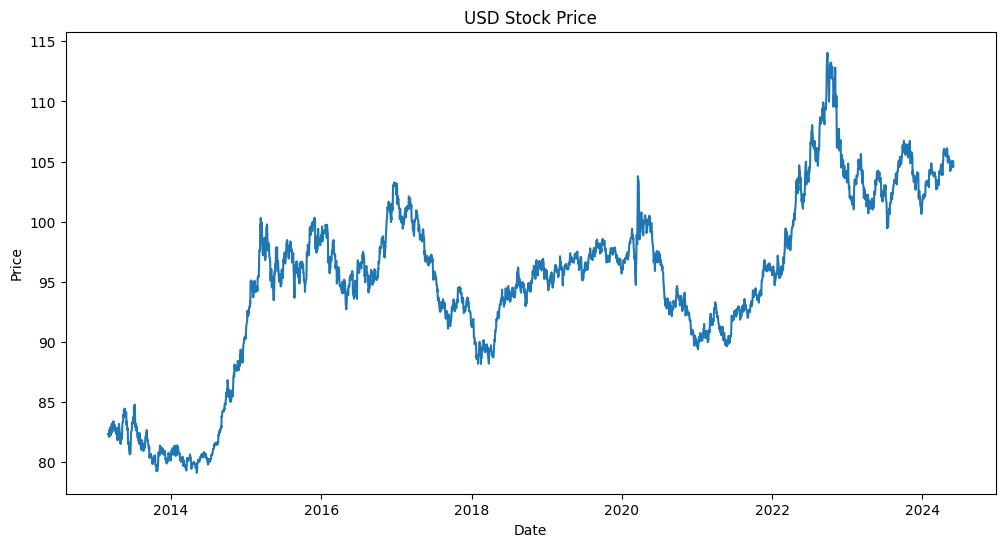

In [43]:
# Visualize the Bitcoin price data
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Price'])
plt.title('USD Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### RETIO 6:4

In [44]:
# Split the data into training and testing sets 6:4
train_size = int(0.6 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Perform Gauss-Newton optimization on the training data
x_train = np.arange(len(train_data))
y_train = train_data['Price'].values

In [45]:
# Define the model function and its Jacobian for Gauss-Newton optimization
def model_func(params, x):
    a, b, c = params
    return a * np.exp(b * x) + c

def model_jac(params, x):
    a, b, c = params
    J = np.empty((x.size, params.size))
    J[:, 0] = np.exp(b * x)
    J[:, 1] = a * x * np.exp(b * x)
    J[:, 2] = 1
    return J

In [46]:
# Initial parameters guess
p0 = np.array([1.0, 0.01, 0.0])

# Gauss-Newton optimization using scipy's least_squares
res = least_squares(lambda params: model_func(params, x_train) - y_train, p0, jac=lambda params: model_jac(params, x_train))

# Extract optimized parameters
a, b, c = res.x

In [47]:
# Function to predict prices for next `n` days
def predict_future_prices(a, b, c, n):
    # Generate future dates and x values
    future_dates = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n)
    future_x = np.arange(len(data), len(data) + n)
    future_y = model_func([a, b, c], future_x)
    return future_dates, future_y

# Predict future prices for the next 30, 60, and 90 days
future_dates_30, future_prices_30 = predict_future_prices(a, b, c, 30)
future_dates_60, future_prices_60 = predict_future_prices(a, b, c, 60)
future_dates_90, future_prices_90 = predict_future_prices(a, b, c, 90)

# Predict test data
x_test = np.arange(train_size, len(data))
pred_test = model_func([a, b, c], x_test)

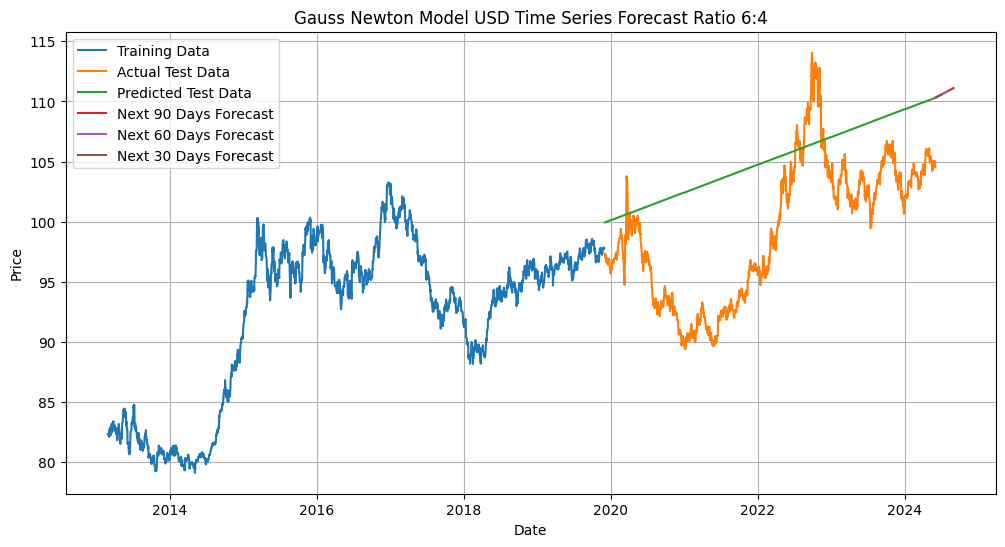

In [48]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Price'], label='Training Data')
plt.plot(test_data['Date'], test_data['Price'], label='Actual Test Data')
plt.plot(test_data['Date'], pred_test, label='Predicted Test Data')
plt.plot(future_dates_90, future_prices_90, label='Next 90 Days Forecast')
plt.plot(future_dates_60, future_prices_60, label='Next 60 Days Forecast')
plt.plot(future_dates_30, future_prices_30, label='Next 30 Days Forecast')
plt.title('Gauss Newton Model USD Time Series Forecast Ratio 6:4')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data['Price'].values if isinstance(test_data['Price'], pd.Series) else test_data['Price']

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Define function for Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate RMSE, MAE, MAPE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
test_mae = np.mean(np.abs(test_data - pred_test))
test_mape = mean_absolute_percentage_error(test_data, pred_test)

# Print RMSE, MAE, MAPE
print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)

Testing RMSE:  7.275040725937645
Testing MAE:  6.341757119772996
Testing MAPE:  6.5761649836730305


### RETIO 7:3

In [50]:
# Split the data into training and testing sets 7:3
train_size = int(0.7 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Perform Gauss-Newton optimization on the training data
x_train = np.arange(len(train_data))
y_train = train_data['Price'].values

In [51]:
# Define the model function and its Jacobian for Gauss-Newton optimization
def model_func(params, x):
    a, b, c = params
    return a * np.exp(b * x) + c

def model_jac(params, x):
    a, b, c = params
    J = np.empty((x.size, params.size))
    J[:, 0] = np.exp(b * x)
    J[:, 1] = a * x * np.exp(b * x)
    J[:, 2] = 1
    return J

In [52]:
# Initial parameters guess
p0 = np.array([1.0, 0.01, 0.0])

# Gauss-Newton optimization using scipy's least_squares
res = least_squares(lambda params: model_func(params, x_train) - y_train, p0, jac=lambda params: model_jac(params, x_train))

# Extract optimized parameters
a, b, c = res.x

In [53]:
# Function to predict prices for next `n` days
def predict_future_prices(a, b, c, n):
    # Generate future dates and x values
    future_dates = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n)
    future_x = np.arange(len(data), len(data) + n)
    future_y = model_func([a, b, c], future_x)
    return future_dates, future_y

# Predict future prices for the next 30, 60, and 90 days
future_dates_30, future_prices_30 = predict_future_prices(a, b, c, 30)
future_dates_60, future_prices_60 = predict_future_prices(a, b, c, 60)
future_dates_90, future_prices_90 = predict_future_prices(a, b, c, 90)

# Predict test data
x_test = np.arange(train_size, len(data))
pred_test = model_func([a, b, c], x_test)

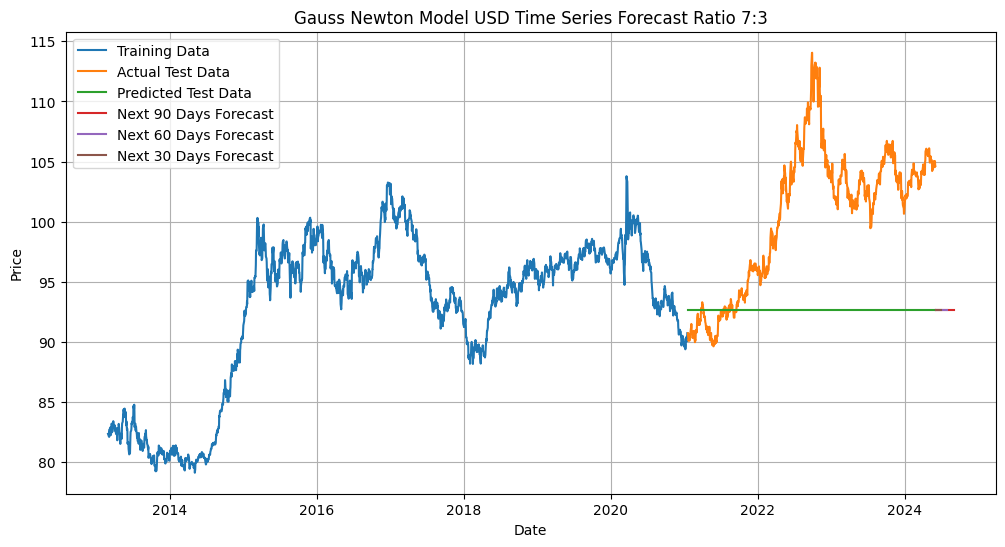

In [54]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Price'], label='Training Data')
plt.plot(test_data['Date'], test_data['Price'], label='Actual Test Data')
plt.plot(test_data['Date'], pred_test, label='Predicted Test Data')
plt.plot(future_dates_90, future_prices_90, label='Next 90 Days Forecast')
plt.plot(future_dates_60, future_prices_60, label='Next 60 Days Forecast')
plt.plot(future_dates_30, future_prices_30, label='Next 30 Days Forecast')
plt.title('Gauss Newton Model USD Time Series Forecast Ratio 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data['Price'].values if isinstance(test_data['Price'], pd.Series) else test_data['Price']

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Define function for Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate RMSE, MAE, MAPE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
test_mae = np.mean(np.abs(test_data - pred_test))
test_mape = mean_absolute_percentage_error(test_data, pred_test)

# Print RMSE, MAE, MAPE
print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)

Testing RMSE:  9.7934562468708
Testing MAE:  8.269167427945511
Testing MAPE:  7.954064034816623


### RETIO 8:2

In [56]:
# Split the data into training and testing sets 8:2
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Perform Gauss-Newton optimization on the training data
x_train = np.arange(len(train_data))
y_train = train_data['Price'].values

In [57]:
# Define the model function and its Jacobian for Gauss-Newton optimization
def model_func(params, x):
    a, b, c = params
    return a * np.exp(b * x) + c

def model_jac(params, x):
    a, b, c = params
    J = np.empty((x.size, params.size))
    J[:, 0] = np.exp(b * x)
    J[:, 1] = a * x * np.exp(b * x)
    J[:, 2] = 1
    return J

In [58]:
# Initial parameters guess
p0 = np.array([1.0, 0.01, 0.0])

# Gauss-Newton optimization using scipy's least_squares
res = least_squares(lambda params: model_func(params, x_train) - y_train, p0, jac=lambda params: model_jac(params, x_train))

# Extract optimized parameters
a, b, c = res.x

In [59]:
# Function to predict prices for next `n` days
def predict_future_prices(a, b, c, n):
    # Generate future dates and x values
    future_dates = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n)
    future_x = np.arange(len(data), len(data) + n)
    future_y = model_func([a, b, c], future_x)
    return future_dates, future_y

# Predict future prices for the next 30, 60, and 90 days
future_dates_30, future_prices_30 = predict_future_prices(a, b, c, 30)
future_dates_60, future_prices_60 = predict_future_prices(a, b, c, 60)
future_dates_90, future_prices_90 = predict_future_prices(a, b, c, 90)

# Predict test data
x_test = np.arange(train_size, len(data))
pred_test = model_func([a, b, c], x_test)

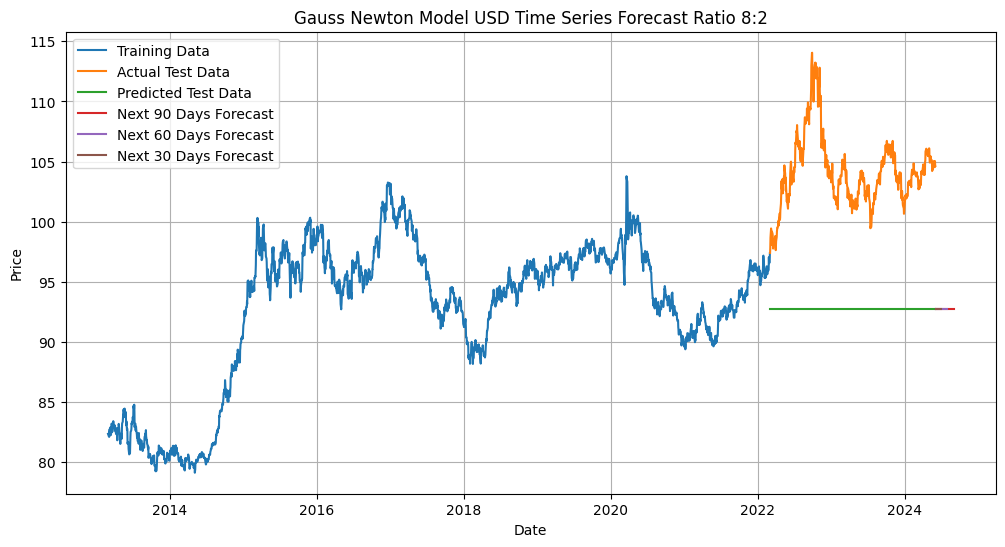

In [60]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Price'], label='Training Data')
plt.plot(test_data['Date'], test_data['Price'], label='Actual Test Data')
plt.plot(test_data['Date'], pred_test, label='Predicted Test Data')
plt.plot(future_dates_90, future_prices_90, label='Next 90 Days Forecast')
plt.plot(future_dates_60, future_prices_60, label='Next 60 Days Forecast')
plt.plot(future_dates_30, future_prices_30, label='Next 30 Days Forecast')
plt.title('Gauss Newton Model USD Time Series Forecast Ratio 8:2')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
# Convert pred_test and test_data to numpy arrays if they are pandas Series
pred_test = pred_test.values if isinstance(pred_test, pd.Series) else pred_test
test_data = test_data['Price'].values if isinstance(test_data['Price'], pd.Series) else test_data['Price']

# Ensure both arrays have the same length
if len(pred_test) != len(test_data):
    raise ValueError("Length of pred_test and test_data must be the same")

# Define function for Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate RMSE, MAE, MAPE for the testing set
test_rmse = np.sqrt(np.mean((pred_test - test_data)**2))
test_mae = np.mean(np.abs(test_data - pred_test))
test_mape = mean_absolute_percentage_error(test_data, pred_test)

# Print RMSE, MAE, MAPE
print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)

Testing RMSE:  11.848757145751165
Testing MAE:  11.47183529337601
Testing MAPE:  10.941569660529312
